#### **Library imports**

In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Load dataset**

In [4]:
dataset = 'movielens'

train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

n_users, n_items, n_samples_train, n_samples_test

(943, 1682, 159619, 40381)

#### **Defining collaborative filtering**

In [155]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        drop_u = nn.Dropout(p = 0.3)
        drop_i = nn.Dropout(p = 0.3)
        u = self.user_emb(user)
        i = self.item_emb(item)
        u = drop_u(u)
        i = drop_i(i)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

class NCF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.fc1 = nn.Linear(n_factors * 2, n_factors)
        self.fc2 = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()
        swish = nn.SiLU()

        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.concat([u, i], dim = 1)
        x = swish(x)
        x = self.fc1(x)
        x = swish(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Test collaborative filtering on unseen data**

In [153]:
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

In [164]:
# lr = 1 and T = 1000, Adam giving 77% accuracy on test data
# lr = 1.1 and T = 500, Adam giving 77.2% accuracy on test data
# lr = 1.4 and T = 250, Adam giving 76.8% accuracy on test data
# lr = 1.8 and T = 250, Adam giving 77.2% accuracy on test data
# lr = 1.6 and T = 250, Adam giving 77% accuracy on test data but making meta-gradients infinite
# lr = 500, T = 300, SGD, Dropout = 0.3 gives 75.58% accuracy on test data
# lr = 1000, T = 300, SGD, Dropout = 0.3, seed = 0 gives 76% accuracy on test data
# lr = 1000, T = 300, SGD, Dropout = 0.3, seed = 50 gives 76.18% accuracy on test data

n_factors = 64
T = 300
seed = 50

# for lr in list(range(1, 500, 5)):
for lr in [1000]:

    model = CollaborativeFiltering(n_users, n_items, n_factors)
    model.to(device)

    torch.manual_seed(seed)
    for layer in model.children():
        layer.reset_parameters()
    # optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    loss_fn = torch.nn.BCELoss(reduction = 'mean')

    model.train()
    for _ in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()

    model.eval()
    y_hat = model(users, items)
    print('lr: ', lr)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    loss = loss_fn(y_hat, ratings)
    meta_grad = torch.autograd.grad(loss, ratings)[0]
    print('max meta grad: ', meta_grad.max())
    print('min meta grad: ', meta_grad.min())
    print(meta_grad)
    y_hat = model(users_test, items_test)
    print('Testing accuracy: ', get_accuracy(y_hat, ratings_test))
    print()


lr:  1000
Training accuracy:  0.9091523885726929
max meta grad:  tensor(0.0003, device='cuda:6')
min meta grad:  tensor(-inf, device='cuda:6')
tensor([ 3.1337e-06, -1.8015e-05, -4.1825e-05,  ..., -2.6589e-06,
         5.7238e-05,  1.4330e-06], device='cuda:6')
Testing accuracy:  0.7618434429168701



#### **Code for surrogate meta-attack (surrogate-CF-SGD, evaluation-CF-Adam, same-init)**

In [167]:
# model settings
algorithm = 'meta'
surrogate = 'CF'
target = 'CF'
opt_surrogate = 'sgd'
opt_target = 'sgd'
lr_surrogate = 1000
lr_target = 1000
seed_surrogate = 0
seed_target = 50

# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparameters
T = 300
Delta = 10000 # 5% ~ 10K perturbations for movielens
n_factors = 64
save_results = True
retain_graph = True 
create_graph = False

if Delta < 100:
    save_results = False

# initialize list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['accuracy_unseen'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []
perturbations['loss_unseen'] = []

perturbations['accuracy_before_eval'] = []
perturbations['accuracy_after_eval'] = []
perturbations['accuracy_unseen_eval'] = []
perturbations['loss_before_eval'] = []
perturbations['loss_after_eval'] = []
perturbations['loss_unseen_eval'] = []

# print hyperparam configuration
print('-> Algorithm: ', algorithm)
print()
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples_train, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print()
print('-> Surrogate: ', surrogate)
print('-> Target: ', target)
print('-> Surrogate optimizer: ', opt_surrogate)
print('-> Target optimizer: ', opt_target)
print('-> Surrogate learning rate: ', lr_surrogate)
print('-> Target learning rate: ', lr_target)
print('-> Surrogate seed: ', seed_surrogate)
print('-> Target seed: ', seed_target)
print()
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

if 'NCF' in surrogate:
    ratings = ratings.reshape((n_samples_train, 1))
perturbs = torch.ones_like(ratings).bool()

# sample random negative edges to perturb
if 'base' in algorithm:
    edges = ratings.detach().to('cpu').numpy()
    neg_edges = np.where(edges == 0)[0]
    np.random.seed(0)
    edges_to_perturb = np.random.choice(neg_edges, size=Delta, replace = True) # sample Delta edges randomly and perturb one by one inside loop 

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # define surrogate model and it's parameters
    if 'NCF' in surrogate:
        model = NCF(n_users, n_items, n_factors)
    else:
        model = CollaborativeFiltering(n_users, n_items, n_factors)
    model.to(device)

    # reset model paramters 
    torch.manual_seed(seed_surrogate)
    for layer in model.children():
        layer.reset_parameters()

    # define optimizer and loss function
    if 'adam' in opt_surrogate:
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_surrogate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr = lr_surrogate)
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()
    model.eval()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())

    # compute and store accuracy of surrogate model on unseen data
    with torch.no_grad():
        y_hat = model(users_test, items_test)
        perturbations['accuracy_unseen'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss_unseen'].append(loss_fn(y_hat, ratings_test).item())

    # compute meta gradient
    if 'meta' in algorithm:
        meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model
    if 'NCF' in target:
        eval_model = NCF(n_users, n_items, n_factors)
    else:
        eval_model = CollaborativeFiltering(n_users, n_items, n_factors)
    eval_model.to(device)

    # reset evaluation model parameters
    torch.manual_seed(seed_target)
    for layer in eval_model.children():
        layer.reset_parameters()

    # define optimizer and loss function for evaluation
    if 'adam' in opt_target:
        optimizer_eval = torch.optim.Adam(eval_model.parameters(), lr = lr_target)
    else:
        optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr_target)
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings and perturbs for eval model
    ratings_eval = ratings.detach().clone()
    perturbs_eval = perturbs.detach().clone()

    # reshape ratings and perturbs if necessary
    # later add code for reshaping ratings_test as well (incomplete right now)
    if surrogate != target:
        if 'NCF' in target:
            ratings_eval = ratings_eval.reshape((n_samples_train, 1))
            perturbs_eval = perturbs_eval.reshape((n_samples_train, 1))
        else:
            ratings_eval = ratings_eval.reshape((n_samples_train))
            perturbs_eval = perturbs_eval.reshape((n_samples_train))

    # inner train  evaluation model
    eval_model.train()
    for i in range(T):
        y_hat = eval_model(users, items)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()
    eval_model.eval()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items)
        perturbations['accuracy_before_eval'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss_before_eval'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs_eval)
        ratings_masked = torch.masked_select(ratings_eval, perturbs_eval)
        perturbations['accuracy_after_eval'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after_eval'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

    # compute and store accuracy of target model on unseen data
    with torch.no_grad():
        y_hat = eval_model(users_test, items_test)
        perturbations['accuracy_unseen_eval'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss_unseen_eval'].append(loss_fn(y_hat, ratings_test).item())

    # select best edge and perform perturbation
    with torch.no_grad():
        if 'meta' in algorithm:
            mask = ratings.detach().int()
            meta_grad[mask == 1] = 0
            best_edge = meta_grad.argmax().item()
            ratings[best_edge] = 1
            perturbs[best_edge] = False

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(meta_grad[best_edge].item())

        else:
            best_edge = edges_to_perturb[delta]
            ratings[best_edge] = 1 
            perturbs[best_edge] = False

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(-1)

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# process results
perturbations = pd.DataFrame(perturbations)
filename = '{}({})-{}({})-{}-D={}-T={}-lr({},{})-seed({},{})'.format(surrogate, opt_surrogate, target, opt_target, algorithm, Delta, T, lr_surrogate, lr_target, seed_surrogate, seed_target)
if save_results:
    perturbations.to_csv('results/' + dataset + '/' + filename + '.csv')

-> Algorithm:  meta

-> T:  300
-> Delta: 10000 (6.26%)
-> Embedding size:  64
-> Device:  cuda:6

-> Surrogate:  CF
-> Target:  CF
-> Surrogate optimizer:  sgd
-> Target optimizer:  sgd
-> Surrogate learning rate:  1000
-> Target learning rate:  1000
-> Surrogate seed:  0
-> Target seed:  50

-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 10000/10000 [2:40:22<00:00,  1.04it/s] 


-> Execution time: 02h 40m 23s


In [168]:
print('File name: ', filename)
if 'meta' in algorithm:
    print('Max meta-gradient: ', perturbations['metagrad'].max())
perturbations

File name:  CF(sgd)-CF(sgd)-meta-D=10000-T=300-lr(1000,1000)-seed(0,50)
Max meta-gradient:  0.00025150133296847343


,edges,metagrad,accuracy_before,accuracy_after,accuracy_unseen,loss_before,loss_after,loss_unseen,accuracy_before_eval,accuracy_after_eval,accuracy_unseen_eval,loss_before_eval,loss_after_eval,loss_unseen_eval
0,64572,0.000252,0.908213,0.908213,0.760556,0.213116,0.213116,0.724937,0.909152,0.909152,0.761843,0.211837,0.211837,0.724220
1,45202,0.000244,0.908094,0.908093,0.759912,0.213170,0.213171,0.725120,0.908902,0.908907,0.762141,0.212384,0.212378,0.725803
2,136204,0.000241,0.907993,0.907999,0.760803,0.213313,0.213290,0.724132,0.908839,0.908838,0.761868,0.212368,0.212371,0.724222
3,1810,0.000231,0.907924,0.907923,0.759689,0.213443,0.213447,0.725339,0.909134,0.909138,0.762116,0.211804,0.211801,0.724209
4,111703,0.000232,0.907874,0.907872,0.760308,0.213378,0.213383,0.724941,0.909027,0.909025,0.761843,0.211630,0.211632,0.723913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,68592,0.000048,0.870780,0.877660,0.708502,0.295964,0.281563,0.786965,0.882245,0.887331,0.707882,0.271749,0.261128,0.822038
9996,126611,0.000048,0.870717,0.877579,0.708551,0.295908,0.281516,0.786867,0.882301,0.887397,0.707981,0.271762,0.261151,0.821963
9997,115370,0.000048,0.870799,0.877638,0.708848,0.295924,0.281529,0.786675,0.882288,0.887436,0.708105,0.271747,0.261129,0.821770
9998,83334,0.000047,0.870799,0.877718,0.708204,0.295871,0.281476,0.786680,0.882357,0.887509,0.707981,0.271724,0.261085,0.821525


In [169]:
ratings.shape

torch.Size([159619])

In [170]:
ratings_test.shape

torch.Size([40381])

In [171]:
perturbations.edges.nunique()

10000

#### **Plots**

In [178]:
# Process perturbations data
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Accuracy unseen (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Loss unseen (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Accuracy unseen (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)', 'Loss unseen (target)']
perturbations_reset

,# Perturbations,Perturbed edge,Meta gradient,Accuracy including perturbed edges (surrogate),Accuracy excluding perturbed edges (surrogate),Accuracy unseen (surrogate),Loss including perturbed edges (surrogate),Loss excluding perturbed edges (surrogate),Loss unseen (surrogate),Accuracy including perturbed edges (target),Accuracy excluding perturbed edges (target),Accuracy unseen (target),Loss including perturbed edges (target),Loss excluding perturbed edges (target),Loss unseen (target)
0,0,64572,0.000252,0.908213,0.908213,0.760556,0.213116,0.213116,0.724937,0.909152,0.909152,0.761843,0.211837,0.211837,0.724220
1,1,45202,0.000244,0.908094,0.908093,0.759912,0.213170,0.213171,0.725120,0.908902,0.908907,0.762141,0.212384,0.212378,0.725803
2,2,136204,0.000241,0.907993,0.907999,0.760803,0.213313,0.213290,0.724132,0.908839,0.908838,0.761868,0.212368,0.212371,0.724222
3,3,1810,0.000231,0.907924,0.907923,0.759689,0.213443,0.213447,0.725339,0.909134,0.909138,0.762116,0.211804,0.211801,0.724209
4,4,111703,0.000232,0.907874,0.907872,0.760308,0.213378,0.213383,0.724941,0.909027,0.909025,0.761843,0.211630,0.211632,0.723913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,68592,0.000048,0.870780,0.877660,0.708502,0.295964,0.281563,0.786965,0.882245,0.887331,0.707882,0.271749,0.261128,0.822038
9996,9996,126611,0.000048,0.870717,0.877579,0.708551,0.295908,0.281516,0.786867,0.882301,0.887397,0.707981,0.271762,0.261151,0.821963
9997,9997,115370,0.000048,0.870799,0.877638,0.708848,0.295924,0.281529,0.786675,0.882288,0.887436,0.708105,0.271747,0.261129,0.821770
9998,9998,83334,0.000047,0.870799,0.877718,0.708204,0.295871,0.281476,0.786680,0.882357,0.887509,0.707981,0.271724,0.261085,0.821525


File name:  CF(sgd)-CF(sgd)-meta-D=10000-T=300-lr(1000,1000)-seed(0,50)


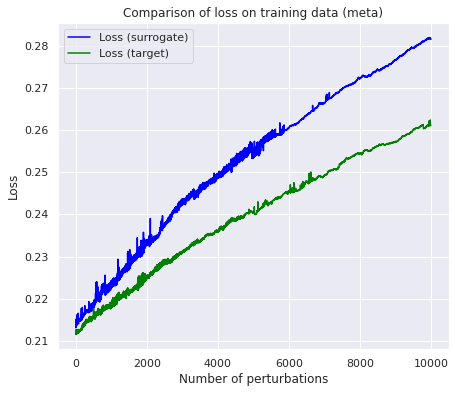

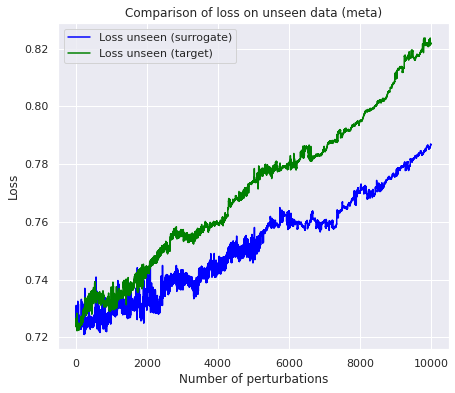

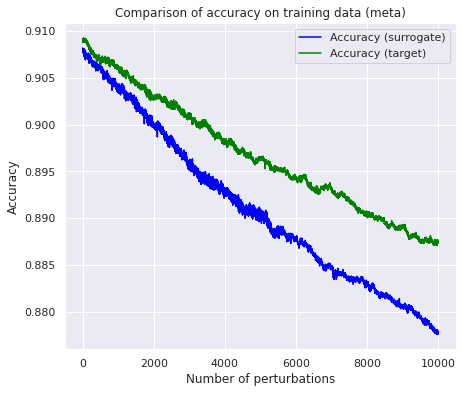

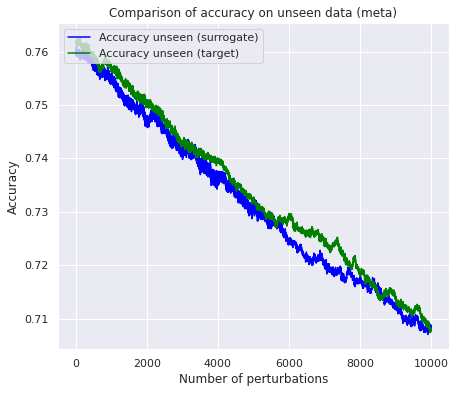

In [182]:
# Process perturbations data
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Accuracy unseen (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Loss unseen (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Accuracy unseen (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)', 'Loss unseen (target)']
perturbations_reset

# Figure specifications
sns.set_theme()
figsize = (7, 6)
print('File name: ', filename)

# Loss plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'], loc = 'upper left')
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-' + filename)
plt.show()

# Loss on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (surrogate)', color = 'blue').set_title('Comparison of loss on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss unseen (surrogate)', 'Loss unseen (target)'], loc = 'upper left')
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-unseen-' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/accuracy-' + filename)
plt.show()

# Accuracy on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (surrogate)', color = 'blue').set_title('Comparison of accuracy on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy unseen (surrogate)', 'Accuracy unseen (target)'], loc = 'upper left')
if save_results: 
    fig.savefig('plots/' + dataset + '/accuracy-unseen-' + filename)
plt.show()